#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель работы:** построить модель, предсказывающую количество заказов такси на следующий час.

**Ход работы:**
1. Подготовка данных;
2. Анализ данных;
3. Обучение моделей;
4. Тестирование.

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Загрузим предоставленные данные.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.shape

(26496, 1)

Отсортируем индексы в хронологическом порядке, а затем выполним ресемплирование по 1 часу.

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Оценим временной промежуток предоставленных данных.

In [5]:
print(data.index.min(), '-' , data.index.max())

2018-03-01 00:00:00 - 2018-08-31 23:00:00


## Анализ

Разложим данные на тренд и сезонную компоненту и построим их графики.

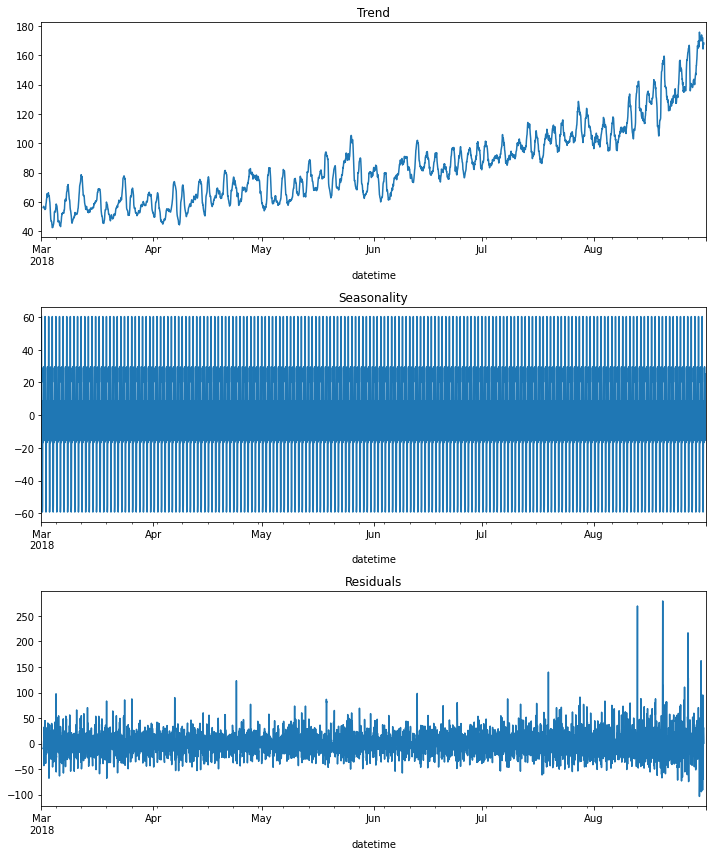

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Тренд показывет почти линейный рост числа заказов в зависимости от времени. Чтобы оценить сезонность, построим график сезонной составляющей за первые 15 дней августа 2018.

<AxesSubplot:xlabel='datetime'>

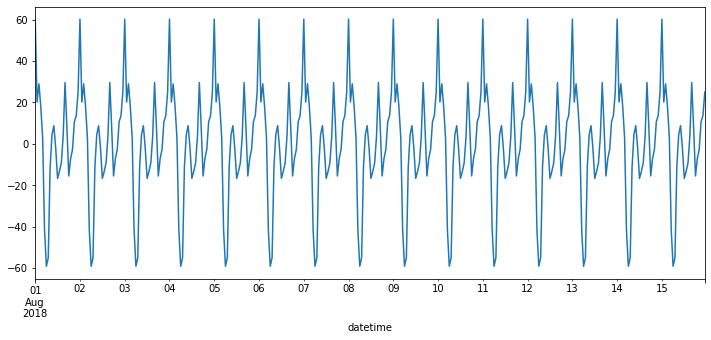

In [7]:
plt.figure(figsize=(12, 5))
decomposed.seasonal['2018-08-01':'2018-08-15'].plot()

График сезонной составляющей показывает изменение количества заказов такси в зависимости от времени суток - ночью число заказов минимально и растет оно ближе к вечеру.

## Обучение

Напишем функцию для создания признаков.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(data, 30, 30)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборки.

In [10]:
train, test = train_test_split(data, test_size=0.1, shuffle=False, random_state=12345)
train = train.dropna()
print(train.index.min(), '-', train.index.max())
print(test.index.min(), '-', test.index.max())

2018-03-02 06:00:00 - 2018-08-13 13:00:00
2018-08-13 14:00:00 - 2018-08-31 23:00:00


Разделим выборки на признаки и целевой признак.

In [11]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Напишем функцию для подбора гиперпараметров и выбора лучшей модели.

In [12]:
def best_model(model, param):
    cv = TimeSeriesSplit(n_splits=2)
    grid = RandomizedSearchCV(model, param, cv=cv, scoring='neg_root_mean_squared_error')
    grid.fit(features_train, target_train)
    best_model = grid.best_estimator_
    rmse = abs(grid.best_score_)
    print('RMSE:', round(rmse, 2), 'Параметры:', grid.best_params_)
    return best_model

* Дерево решений

In [13]:
model_dt = DecisionTreeRegressor(random_state=12345)
param = {'max_depth': range(1,21,1)}
best_model_dt = best_model(model_dt, param)

RMSE: 34.98 Параметры: {'max_depth': 4}


* Случайный лес

In [14]:
model_rf = RandomForestRegressor(random_state=12345)
param = {'max_depth': range(1,21,1),
         'n_estimators':range(10,100,10)}
best_model_rf = best_model(model_rf, param)

RMSE: 28.38 Параметры: {'n_estimators': 60, 'max_depth': 16}


* Линейная регрессия

In [15]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
cv = TimeSeriesSplit(n_splits=2)
mse = cross_val_score(model_lr, features_train, target_train, cv=cv, scoring='neg_mean_squared_error')
print('RMSE:', round(abs(mse.mean())**0.5, 2))

RMSE: 27.87


## Тестирование

Лучший результат RMSE показала модель линейной регрессии, проведем ее тестирование.

In [16]:
predictions = model_lr.predict(features_test)
print('RMSE:', round(mean_squared_error(target_test, predictions)**0.5, 2))

RMSE: 46.89


Построим графики реального и предсказанного рядов.

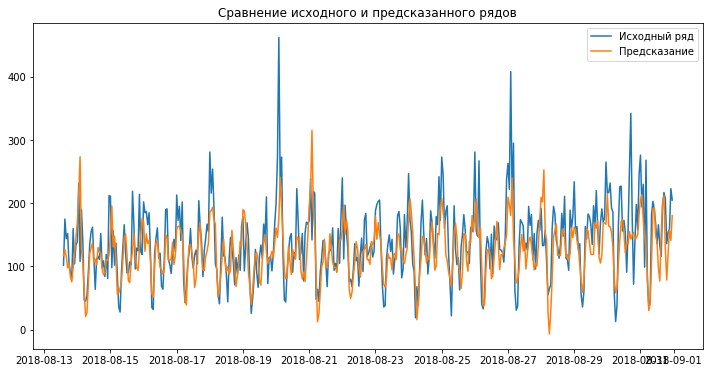

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(target_test, label='Исходный ряд')
plt.plot(target_test.index, predictions, label='Предсказание')
plt.title('Сравнение исходного и предсказанного рядов')
plt.legend()
plt.show();

## Вывод

В ходе данной работы были пронализированы данные о заказах такси и были построены несколько моделей для прогнозирования количества заказов на следующий час. В результате была выбрана модель линейной регрессии, RMSE на тестовой выборке 46.89.